In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [184]:
df_future = pd.read_csv('Final data.csv')

In [185]:
df_future

,Date,CPI,Median Annual Income,Population Estimate,Petrol Price,Diesel Price,Google Search Index,All Cars,ULEV
0,31-10-2011,94.5,26719.28962,430572.0765,1.3473,1.4027,23.0,206427.0,31.0
1,30-11-2011,94.6,26652.97814,430979.3716,1.3317,1.4110,22.0,207544.0,31.0
2,31-12-2011,95.1,26584.45628,431400.2432,1.3241,1.4077,12.0,208700.0,31.0
3,31-01-2012,94.6,26515.93443,431821.1148,1.3410,1.4245,21.0,209690.0,31.0
4,29-02-2012,95.1,26451.83333,432214.8333,1.3621,1.4392,26.0,210618.0,33.0
...,...,...,...,...,...,...,...,...,...
178,31-08-2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,30-09-2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180,31-10-2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181,30-11-2026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
df_future['Date']=pd.to_datetime(df_future['Date'])

In [187]:
df_future.set_index('Date', inplace=True)

In [188]:
df_future.isna().sum()

CPI                     65
Median Annual Income    68
Population Estimate     68
Petrol Price            65
Diesel Price            65
Google Search Index     65
All Cars                72
ULEV                    65
dtype: int64

In [189]:
df_future=df_future.drop(columns=['CPI','Population Estimate','Petrol Price'])

In [190]:
df=df_future.dropna()

In [191]:
df

,Median Annual Income,Diesel Price,Google Search Index,All Cars,ULEV
Date,,,,,
2011-10-31,26719.28962,1.4027,23.0,206427.0,31.0
2011-11-30,26652.97814,1.4110,22.0,207544.0,31.0
2011-12-31,26584.45628,1.4077,12.0,208700.0,31.0
2012-01-31,26515.93443,1.4245,21.0,209690.0,31.0
2012-02-29,26451.83333,1.4392,26.0,210618.0,33.0
...,...,...,...,...,...
2020-08-31,32819.57260,1.1818,65.0,182533.0,1719.0
2020-09-30,32779.95616,1.1814,79.0,182451.0,1795.0
2020-10-31,32739.01918,1.1808,72.0,182366.0,1874.0


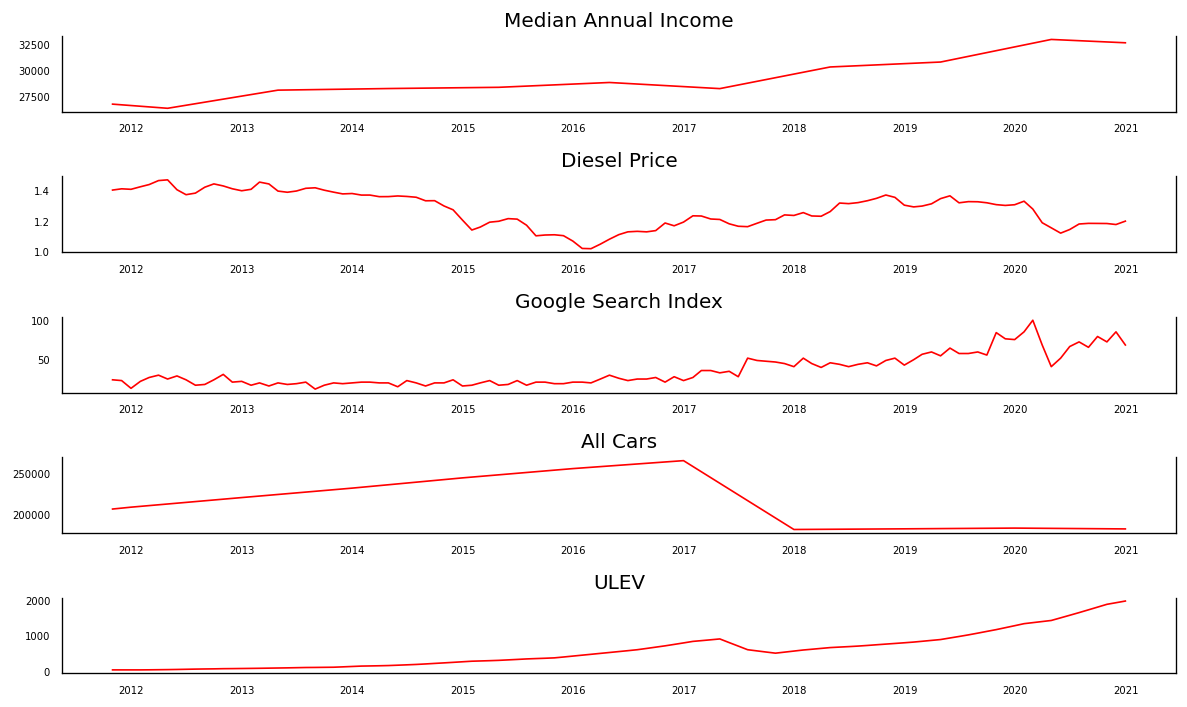

In [192]:
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [193]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        


,Median Annual Income_x,Diesel Price_x,Google Search Index_x,All Cars_x,ULEV_x
Median Annual Income_y,1.0000,0.0041,0.0000,0.0000,0.0121
Diesel Price_y,0.2540,1.0000,0.1988,0.1441,0.2902
Google Search Index_y,0.0001,0.0059,1.0000,0.0293,0.0001
All Cars_y,0.0000,0.0000,0.0026,1.0000,0.0000
ULEV_y,0.0001,0.0154,0.0334,0.0000,1.0000


In [194]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Median Annual Income ::  122.51    > 60.0627   =>   True
Diesel Price ::  72.12     > 40.1749   =>   True
Google Search Index ::  25.92     > 24.2761   =>   True
All Cars ::  10.84     > 12.3212   =>   False
ULEV   ::  0.23      > 4.1296    =>   False


In [195]:
df.shape

(111, 5)

In [196]:
nobs = 12
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(99, 5)
(12, 5)


In [197]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    


In [198]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.0254
 No. Lags Chosen       = 1
 Critical value 1%     = -3.5
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.9606. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Diesel Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4198
 No. Lags Chosen       = 2
 Critical value 1%     = -3.5
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.5727. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Google Search Index" 
    -----------------------------------------------


In [199]:
#1st differentiation
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.9717
 No. Lags Chosen       = 12
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.7634. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Diesel Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.315
 No. Lags Chosen       = 1
 Critical value 1%     = -3.5
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Google Search Index" 
    -----------------------------------------------
 Null Hypothesis: Data 

In [200]:
#2nd differentiation
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8911
 No. Lags Chosen       = 11
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Diesel Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2768
 No. Lags Chosen       = 4
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Google Search Index" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Sta

In [201]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  24.342325078536756
BIC :  25.143683888370454
FPE :  37332899288.56973
HQIC:  24.666247403503043 

Lag Order = 2
AIC :  24.14738019060586
BIC :  25.62594049626933
FPE :  30855996058.306137
HQIC:  24.744829482895742 

Lag Order = 3
AIC :  24.083440181978194
BIC :  26.247946379654792
FPE :  29279990978.198776
HQIC:  24.95774226165588 

Lag Order = 4
AIC :  23.48932865211049
BIC :  26.34871517663836
FPE :  16537986482.295364
HQIC:  24.643867136375388 

Lag Order = 5
AIC :  23.430591716704
BIC :  26.993988619055905
FPE :  16222324277.51544
HQIC:  24.868808899312178 

Lag Order = 6
AIC :  22.038639392970758
BIC :  26.315378112862092
FPE :  4293758952.470332
HQIC:  23.764037097614235 

Lag Order = 7
AIC :  22.343548514356403
BIC :  27.343167855016933
FPE :  6403034248.517831
HQIC:  24.35968891595493 

Lag Order = 8
AIC :  22.122254998916162
BIC :  27.85450731122053
FPE :  5893881545.694257
HQIC:  24.432761405996995 

Lag Order = 9
AIC :  21.3447723820363
BIC :  27.8196299

C:\Users\anich\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [202]:
model_fitted = model.fit(6)
model_fitted.summary()
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(':', round(val, 2))

: 1.99
: 1.9
: 2.16
: 1.94
: 1.99


In [203]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

6


array([[ 5.97540000e+00,  5.43000000e-02,  7.00000000e+00,
         2.00000000e+00,  3.00000000e+00],
       [ 9.99999611e-06, -8.80000000e-03,  2.00000000e+00,
         1.00000000e+00,  4.00000000e+00],
       [-5.97542000e+00, -5.90000000e-03, -6.00000000e+00,
        -3.00000000e+00,  0.00000000e+00],
       [ 5.97542000e+00, -5.50000000e-03,  3.30000000e+01,
         2.00000000e+00,  1.00000000e+00],
       [-5.97542000e+00,  7.10000000e-03, -3.70000000e+01,
        -2.00000000e+00,  4.00000000e+00],
       [ 5.97542000e+00,  9.80000000e-03,  7.00000000e+00,
         3.00000000e+00,  2.00000000e+00]])

In [204]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Median Annual Income_2d,Diesel Price_2d,Google Search Index_2d,All Cars_2d,ULEV_2d
Date,,,,,
2020-01-31,15.436390,0.033766,4.187170,1554.355926,-5.339744
2020-02-29,28.229100,-0.016895,0.952802,-1070.428397,-11.011448
2020-03-31,-31.372946,-0.022620,-2.100959,-219.342719,6.115977
2020-04-30,16.492952,-0.008092,8.570615,623.548849,1.338980
2020-05-31,-55.050688,-0.001290,-8.432704,294.693252,33.292146
2020-06-30,18.199317,0.022050,-3.140707,-42.804134,-19.404550
2020-07-31,13.419162,0.021216,3.071046,-548.715246,-2.040797
2020-08-31,-4.963740,-0.008467,4.500296,231.649938,1.464195
2020-09-30,-4.601417,-0.028272,-1.682361,-261.111616,6.997075


In [205]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [206]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Median Annual Income_forecast','Diesel Price_forecast','Google Search Index_forecast', 'All Cars_forecast','ULEV_forecast']]

,Median Annual Income_forecast,Diesel Price_forecast,Google Search Index_forecast,All Cars_forecast,ULEV_forecast
Date,,,,,
2020-01-31,32459.649510,1.343766,78.187170,184831.355926,1323.660256
2020-02-29,32688.552711,1.365236,82.327143,185392.283456,1363.309065
2020-03-31,32886.082966,1.364087,84.366156,185733.868266,1409.073850
2020-04-30,33100.106173,1.354845,94.975784,186699.001924,1456.177615
2020-05-31,33259.078691,1.344315,97.152708,187958.828835,1536.573526
2020-06-30,33436.250527,1.355833,96.188925,189175.851611,1597.564888
2020-07-31,33626.841525,1.388569,98.296187,189844.159141,1656.515452
2020-08-31,33812.468782,1.412836,104.903746,190744.116610,1716.930212
2020-09-30,33993.494622,1.408832,109.828943,191382.962463,1784.342046


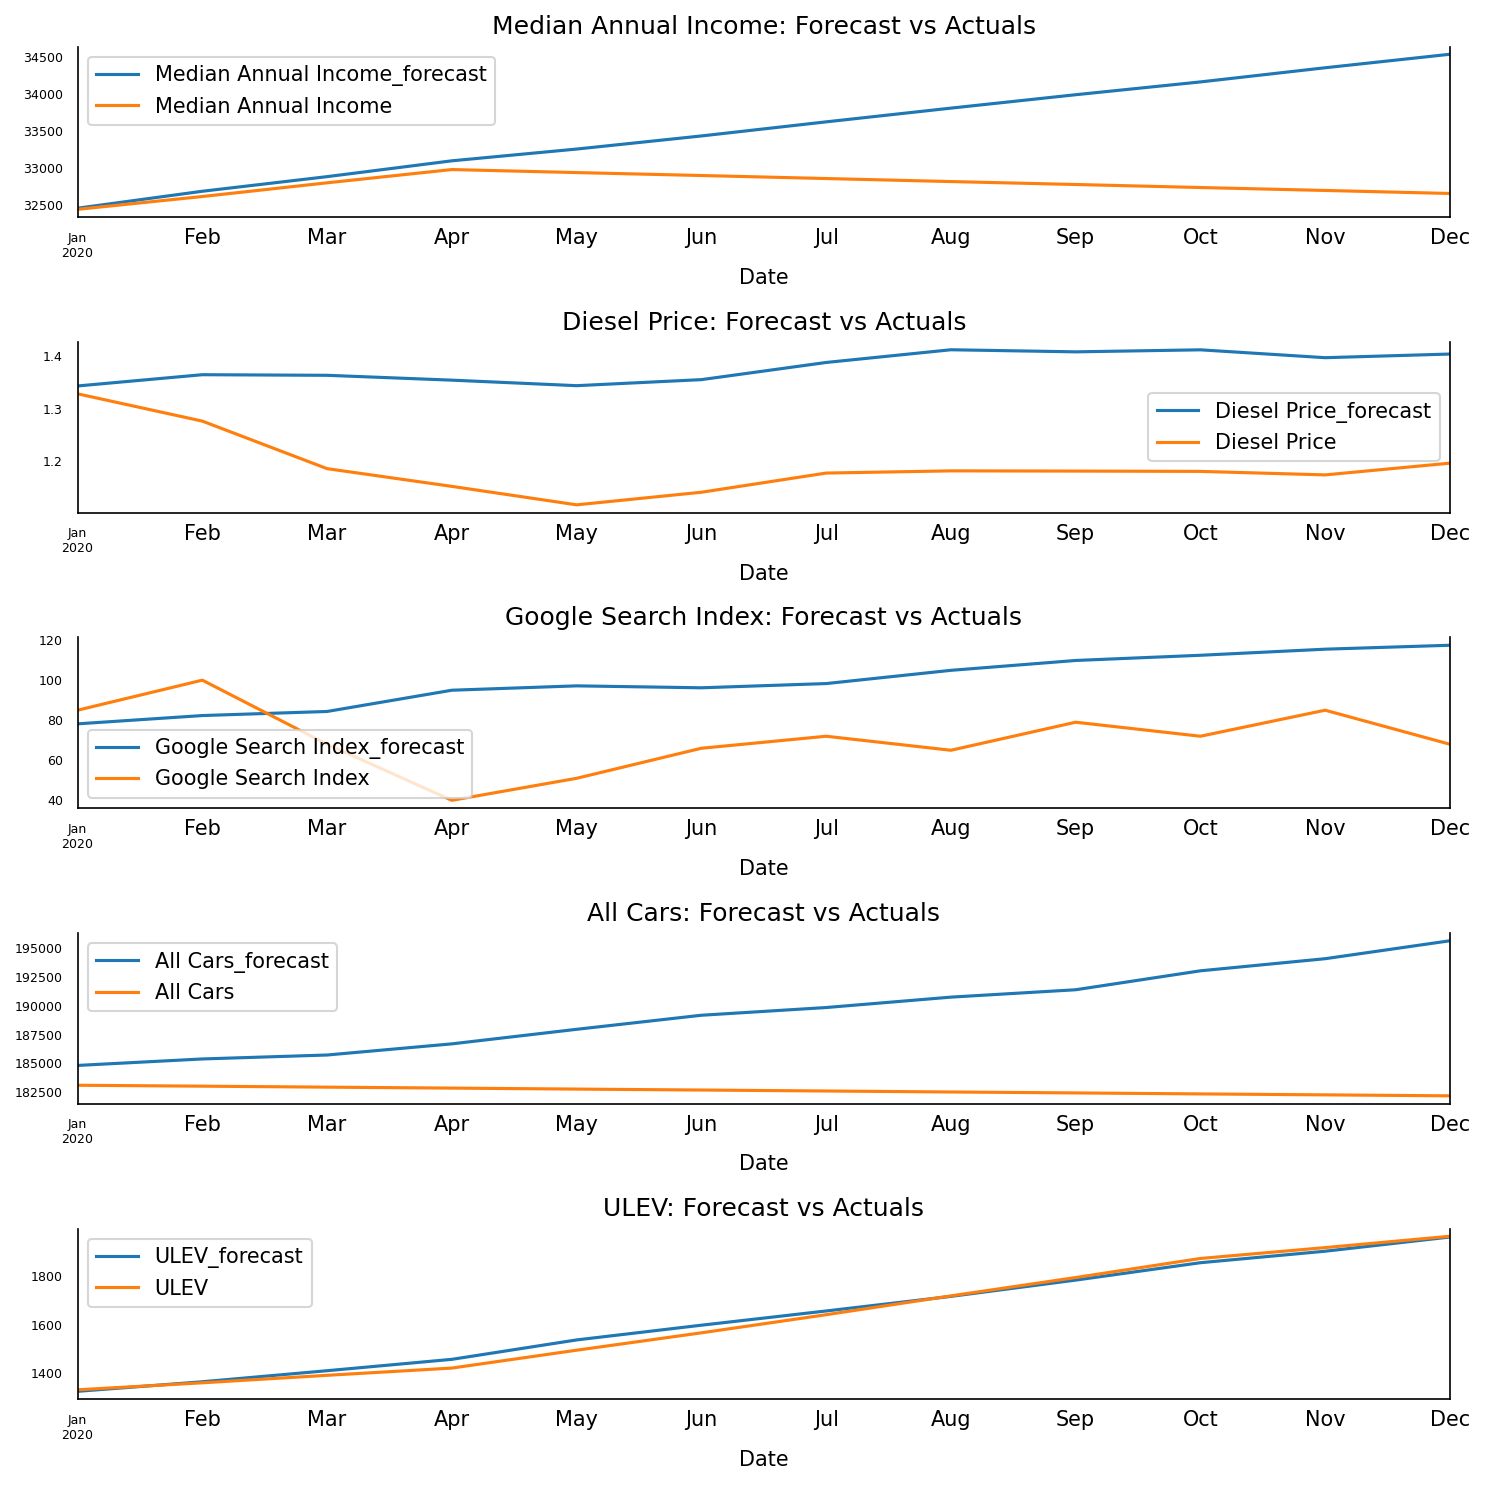

In [207]:
fig, axes = plt.subplots(nrows=int(len(df.columns)), ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

<font size="5"> PREDICTING ULEV CAR SALES TILL 2026: </font> 

In [208]:
fc = model_fitted.forecast(y=forecast_input, steps=84)
df_forecast_2027 = pd.DataFrame(fc, index=df_future.index[-84:], columns=df_future.columns + '_2d')
df_results = invert_transformation(df_train, df_forecast_2027, second_diff=True)        
df_results.loc[:, ['Median Annual Income_forecast','Diesel Price_forecast','Google Search Index_forecast', 'All Cars_forecast','ULEV_forecast']]
df_results['ULEV_forecast']


Date
2020-01-31    1323.660256
2020-02-29    1363.309065
2020-03-31    1409.073850
2020-04-30    1456.177615
2020-05-31    1536.573526
                 ...     
2026-08-31    7462.192652
2026-09-30    7562.249671
2026-10-31    7662.903459
2026-11-30    7764.054527
2026-12-31    7865.806463
Name: ULEV_forecast, Length: 84, dtype: float64

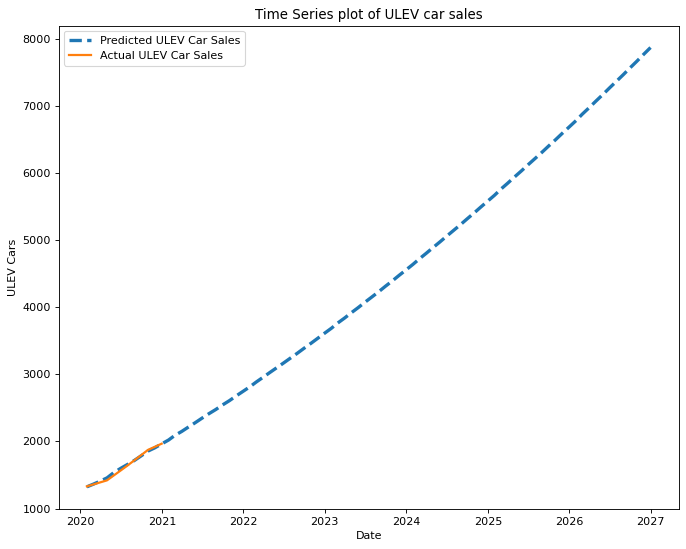

In [209]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)
plt.plot(df_results["ULEV_forecast"],linewidth=3,linestyle='--')
plt.plot(df_test["ULEV"][-nobs:],linewidth=2)
plt.xlabel("Date")
plt.ylabel("ULEV Cars")
plt.title("Time Series plot of ULEV car sales")
plt.legend(['Predicted ULEV Car Sales', 'Actual ULEV Car Sales'])
